In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_mat = scipy.io.loadmat('./Data/data.mat')
face_raw = data_mat['face']
face_raw.shape

(24, 21, 600)

In [3]:
'''
image shape: 24 x 21
image types: neutral face, facial expression, illumination variations
people: 200 subjects
'''
face = face_raw.reshape(24, 21, 200, 3) # image shape x image types x people
neutral_face = face[:, :, :, 0]
facial_expression = face[:, :, :, 1]
illumination = face[:, :, :, 2]

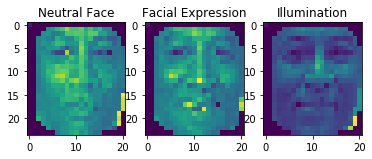

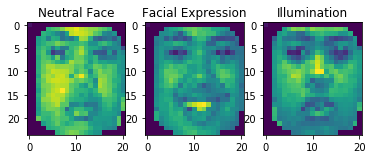

In [4]:
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
ax.set_title('Neutral Face')
plt.imshow(neutral_face[:, :, subject])
ax = fig.add_subplot(1, 3, 2)
ax.set_title('Facial Expression')
plt.imshow(facial_expression[:, :, subject])
ax = fig.add_subplot(1, 3, 3)
ax.set_title('Illumination')
plt.imshow(illumination[:, :, subject])

subject = 30
fig2 = plt.figure()
ax = fig2.add_subplot(1, 3, 1)
ax.set_title('Neutral Face')
plt.imshow(neutral_face[:, :, subject])
ax = fig2.add_subplot(1, 3, 2)
ax.set_title('Facial Expression')
plt.imshow(facial_expression[:, :, subject])
ax = fig2.add_subplot(1, 3, 3)
ax.set_title('Illumination')
plt.imshow(illumination[:, :, subject])

# Neutral Face vs. Facial Expression

In [5]:
# Flatten the images
neutral_face_flatten = neutral_face.reshape(24 * 21, -1)
facial_expression_flatten = facial_expression.reshape(24 * 21, -1)

In [6]:
def train_test_split(data, ratio=0.8):
    # N is the size data
    # D is the dimension of feature
    N, D = data.shape
    train = data[:int(N * 0.8), :]
    test = data[int(N * 0.8):, :]
    return train, test

In [7]:
# Split data into training data and testing data
# Splited data has the shape N, D
# where N is the size data, and D is the dimension of feature

# label neutral face as 0
# label facial expression as 1

nf_train, nf_test = train_test_split(neutral_face_flatten.T)
N, D = nf_train.shape
nf_train_label = np.zeros(N) 
N, D = nf_test.shape
nf_test_label = np.zeros(N) 

fe_train, fe_test = train_test_split(facial_expression_flatten.T)
N, D = fe_train.shape
fe_train_label = np.ones(N) 
N, D = fe_test.shape
fe_test_label = np.ones(N) 

train = np.vstack((nf_train, fe_train))
test = np.vstack((nf_test, fe_test))
train_label = np.hstack((nf_train_label, fe_train_label))
test_label = np.hstack((nf_test_label, fe_test_label))
print("neutral face training data shape: ", nf_train.shape)
print("neutral face testing data shape: ", nf_test.shape)
print("facial expression training data shape: ", fe_train.shape)
print("facial expression testing data shape: ", fe_test.shape)
print("total training data shape: ", train.shape)
print("total testing data shape: ", test.shape)
print("training label shape: ", train_label.shape)
print("testing label shape: ", test_label.shape)

neutral face training data shape:  (160, 504)
neutral face testing data shape:  (40, 504)
facial expression training data shape:  (160, 504)
facial expression testing data shape:  (40, 504)
total training data shape:  (320, 504)
total testing data shape:  (80, 504)
training label shape:  (320,)
testing label shape:  (80,)


## Bayesian Classifier

In [8]:
# Estimate Likelihood (Gaussian)
## ML estimate of mean and covarinace matrix
nf_mean = np.mean(nf_train, axis=0)
print("nf mean shape: ", nf_mean.shape)
nf_cov = np.cov(nf_train.T)
print("nf cov shape: ", nf_cov.shape)

fe_mean = np.mean(fe_train, axis=0)
print("fe mean shape: ", fe_mean.shape)
fe_cov = np.cov(fe_train.T)
print("fe cov shape: ", fe_cov.shape)

nf mean shape:  (504,)
nf cov shape:  (504, 504)
fe mean shape:  (504,)
fe cov shape:  (504, 504)


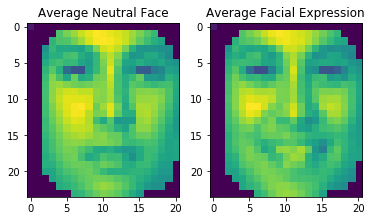

In [9]:
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Average Neutral Face')
plt.imshow(nf_mean.reshape((24, 21)))
ax = fig.add_subplot(1, 2, 2)
ax.set_title('Average Facial Expression')
plt.imshow(fe_mean.reshape((24, 21)))

In [10]:
from scipy.stats import multivariate_normal

# Likelihood (Gaussian)
nf_ml_likelihood = lambda x: multivariate_normal.pdf(x, nf_mean, nf_cov, True)
fe_ml_likelihood = lambda x: multivariate_normal.pdf(x, fe_mean, fe_cov, True)

# Prior
nf_prior = (nf_train.shape[0]) / train.shape[0]
fe_prior = (fe_train.shape[0]) / train.shape[0]

# Posterior 
nf_posterior = lambda x: nf_ml_likelihood(x) * nf_prior
fe_posterior = lambda x: fe_ml_likelihood(x) * fe_prior

In [11]:
def bayes_classifier(data, label, p1, p2):
    """
    data has shape of (N, D) where 
    N is the number of data, and D is the dimension of feature
    
    label is either 0 or 1
    0 is neutral face
    1 is facial expression
    
    p1 is the posterior probability for class 1
    p2 is the posterior probability for class 2
    """
    nf_posterior = p1
    fe_posterior = p2
    
    num_correct = 0
    correct_idxs = []
    for i in range(data.shape[0]):
        target = data[i]
        nf_prob = nf_posterior(target)
        fe_prob = fe_posterior(target)
        if label == 0:
            if (nf_prob > fe_prob):
                num_correct += 1
                correct_idxs.append(i)
        else:
            if (nf_prob < fe_prob):
                num_correct += 1
                correct_idxs.append(i)
    return num_correct, correct_idxs

In [12]:
%%time
# Train Evaluation
nf_train_correct, nf_train_correct_idxs = bayes_classifier(nf_train, 0, nf_posterior, fe_posterior)
nf_train_error = nf_train.shape[0] - nf_train_correct
fe_train_correct, fe_train_correct_idxs = bayes_classifier(fe_train, 1, nf_posterior, fe_posterior)
fe_train_error = fe_train.shape[0] - fe_train_correct

CPU times: user 17min 43s, sys: 54min 23s, total: 1h 12min 6s
Wall time: 4min 32s


In [13]:
%%time
# Test Evaluation
nf_test_correct, nf_test_correct_idxs = bayes_classifier(nf_test, 0, nf_posterior, fe_posterior)
nf_test_error = nf_test.shape[0] - nf_test_correct
fe_test_correct, fe_test_correct_idxs = bayes_classifier(fe_test, 1, nf_posterior, fe_posterior)
fe_test_error = fe_test.shape[0] - fe_test_correct

CPU times: user 3min 48s, sys: 11min 27s, total: 15min 16s
Wall time: 57.3 s
Compiler : 160 ms


Total train accuracy:  0.884375


,Neutral Face,Facial Expression
Predict 0,140,17
Predict 1,20,143


,Neutral Face,Facial Expression
Precision,0.875,0.89375



Example images


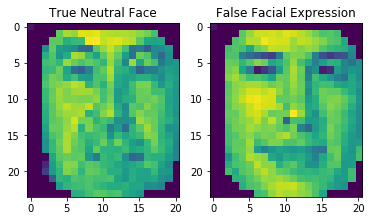

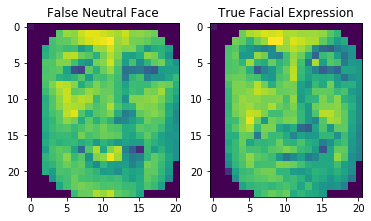

In [14]:
# Train accuracy
print("Total train accuracy: ", (nf_train_correct + fe_train_correct) / train.shape[0])

## Create truth table
train_acc_table = np.array([[nf_train_correct, fe_train_error], 
                            [nf_train_error, fe_train_correct]])
train_acc_df = pd.DataFrame(train_acc_table, columns = ['Neutral Face','Facial Expression'])
train_acc_df = train_acc_df.rename(index={0:'Predict 0', 1:'Predict 1'})
display(train_acc_df)

nf_precision = nf_train_correct / nf_train.shape[0]
fe_precision = fe_train_correct / fe_train.shape[0]
precision_table = np.array([[nf_precision, fe_precision]])
precision_df = pd.DataFrame(precision_table, columns = ['Neutral Face','Facial Expression'])
precision_df = precision_df.rename(index={0:'Precision'})
display(precision_df)


## Calculate false example
nf_train_correct_idxs_set = set(nf_train_correct_idxs)
nf_error_idx = -1
for i in range(nf_train.shape[0]):
    if not i in nf_train_correct_idxs_set:
        nf_error_idx = i
        break

fe_train_correct_idxs_set = set(fe_train_correct_idxs)
fe_error_idx = -1
for i in range(fe_train.shape[0]):
    if not i in fe_train_correct_idxs_set:
        fe_error_idx = i
        break
      
print("")
print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_train[nf_train_correct_idxs[0]].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_train[fe_error_idx].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax.set_title('False Neutral Face')
plt.imshow(nf_train[nf_error_idx].reshape((24, 21)))

ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_train[fe_train_correct_idxs[0]].reshape((24, 21)))

Total test accuracy:  0.75


,Neutral Face,Facial Expression
Predict 0,27,7
Predict 1,13,33


,Neutral Face,Facial Expression
Precision,0.675,0.825



Example images


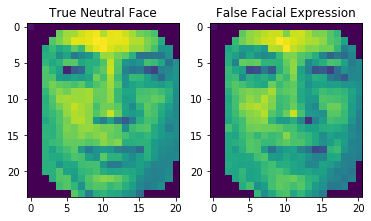

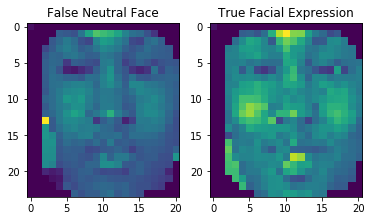

In [15]:
# Test accuracy
print("Total test accuracy: ", (nf_test_correct + fe_test_correct) / test.shape[0])

test_acc_table = np.array([[nf_test_correct, fe_test_error], 
                            [nf_test_error, fe_test_correct]])
test_acc_df = pd.DataFrame(test_acc_table, columns = ['Neutral Face','Facial Expression'])
test_acc_df = test_acc_df.rename(index={0: 'Predict 0', 1:'Predict 1'})
display(test_acc_df)

nf_precision = nf_test_correct / nf_test.shape[0]
fe_precision = fe_test_correct / fe_test.shape[0]
precision_table = np.array([[nf_precision, fe_precision]])
precision_df = pd.DataFrame(precision_table, columns = ['Neutral Face','Facial Expression'])
precision_df = precision_df.rename(index={0:'Precision'})
display(precision_df)

## Calculate false example
nf_test_correct_idxs_set = set(nf_test_correct_idxs)
nf_error_idx = -1
for i in range(nf_test.shape[0]):
    if not i in nf_test_correct_idxs_set:
        nf_error_idx = i
        break

fe_test_correct_idxs_set = set(fe_test_correct_idxs)
fe_error_idx = -1
for i in range(fe_test.shape[0]):
    if not i in fe_test_correct_idxs_set:
        fe_error_idx = i
        break
      
print("")
print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_test[nf_test_correct_idxs[0]].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_test[fe_error_idx].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax.set_title('False Neutral Face')
plt.imshow(nf_test[nf_error_idx].reshape((24, 21)))

ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_test[fe_test_correct_idxs[0]].reshape((24, 21)))

## K Nearest Neighbor

In [16]:
def knn(train_data, train_label, target, k=1):
    """
    data has shape (N, D) 
    where N is the number of data
    and D is the dimension of feature
    
    k is the k in knn. It is a odd number
    """
    assert k%2 != 0, "k needs to be an odd number"
    predict = []
    for i in range(target.shape[0]):
        x = target[i]
        dist_sq_vec = np.sum((train_data - x)**2, axis=1)
        dist_idx_sort = np.argsort(dist_sq_vec)
        if np.mean(train_label[dist_idx_sort[:k]]) > 0.5:
            predict.append(1)
        else:
            predict.append(0)
    return predict

### K=1

In [17]:
%%time
# Train Evaluation
train_predict = knn(train_data=train, train_label=train_label, target=train)
train_correct = np.sum(train_predict==train_label)
print("Total train accuracy: ", train_correct / train_label.shape[0])

Total train accuracy:  1.0
CPU times: user 68.4 ms, sys: 0 ns, total: 68.4 ms
Wall time: 67.9 ms


Total test accuracy:  0.7625


,Neutral Face,Facial Expression
Predict 0,36,15
Predict 1,4,25


,Neutral Face,Facial Expression
Precision,0.9,0.625


Example images
CPU times: user 59.5 ms, sys: 8.56 ms, total: 68.1 ms
Wall time: 63.9 ms


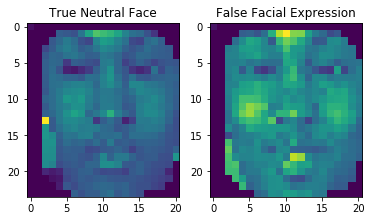

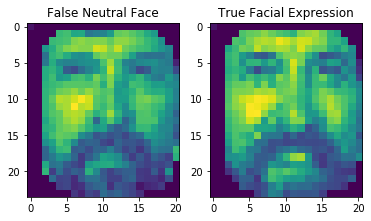

In [18]:
%%time
# Test Evaluation
test_predict = knn(train_data=train, train_label=train_label, target=test)
test_correct = np.sum(test_predict==test_label)
print("Total test accuracy: ", test_correct / test_label.shape[0])


## Create truth table
nf_test_predict = knn(train_data=train, train_label=train_label, target=nf_test)
nf_test_correct = np.sum(nf_test_predict==nf_test_label)
nf_test_error = nf_test.shape[0] - nf_test_correct

fe_test_predict = knn(train_data=train, train_label=train_label, target=fe_test)
fe_test_correct = np.sum(fe_test_predict==fe_test_label)
fe_test_error = fe_test.shape[0] - fe_test_correct

test_acc_table = np.array([[nf_test_correct, fe_test_error], 
                            [nf_test_error, fe_test_correct]])
test_acc_df = pd.DataFrame(test_acc_table, columns = ['Neutral Face','Facial Expression'])
test_acc_df = test_acc_df.rename(index={0: 'Predict 0', 1:'Predict 1'})
display(test_acc_df)

## Calculate precision
nf_precision = nf_test_correct / nf_test.shape[0]
fe_precision = fe_test_correct / fe_test.shape[0]
precision_table = np.array([[nf_precision, fe_precision]])
precision_df = pd.DataFrame(precision_table, columns = ['Neutral Face','Facial Expression'])
precision_df = precision_df.rename(index={0:'Precision'})
display(precision_df)

## Correct and error prediction images 
nf_correct_predict = nf_test[np.where(nf_test_predict==nf_test_label)]
nf_error_predict = nf_test[np.where(nf_test_predict!=nf_test_label)]
fe_correct_predict = fe_test[np.where(fe_test_predict==fe_test_label)]
fe_error_predict = fe_test[np.where(fe_test_predict!=fe_test_label)]

print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_correct_predict[0].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_error_predict[0].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax.set_title('False Neutral Face')
plt.imshow(nf_error_predict[0].reshape((24, 21)))

ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_correct_predict[0].reshape((24, 21)))

In [19]:
# The False positive image index for facial expression when k=1
np.where(fe_test_predict!=fe_test_label)

(array([ 0,  2,  8, 10, 15, 17, 20, 22, 24, 26, 28, 30, 32, 36, 37]),)

### K=3

In [20]:
%%time
# Train Evaluation
train_predict = knn(train_data=train, train_label=train_label, target=train, k=3)
train_correct = np.sum(train_predict==train_label)
print("Total train accuracy: ", train_correct / train_label.shape[0])

Total train accuracy:  0.846875
CPU times: user 60.6 ms, sys: 1.81 ms, total: 62.4 ms
Wall time: 61.1 ms


Total test accuracy:  0.8125


,Neutral Face,Facial Expression
Predict 0,40,15
Predict 1,0,25


,Neutral Face,Facial Expression
Precision,1.0,0.625


Example images
CPU times: user 65.6 ms, sys: 6.42 ms, total: 72 ms
Wall time: 67.3 ms


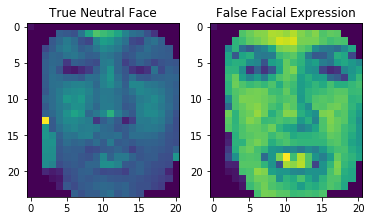

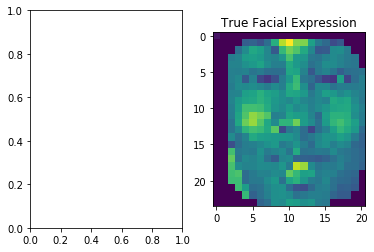

In [21]:
%%time
# Test Evaluation
test_predict = knn(train_data=train, train_label=train_label, target=test, k=3)
test_correct = np.sum(test_predict==test_label)
print("Total test accuracy: ", test_correct / test_label.shape[0])


## Create truth table
nf_test_predict = knn(train_data=train, train_label=train_label, target=nf_test, k=3)
nf_test_correct = np.sum(nf_test_predict==nf_test_label)
nf_test_error = nf_test.shape[0] - nf_test_correct

fe_test_predict = knn(train_data=train, train_label=train_label, target=fe_test, k=3)
fe_test_correct = np.sum(fe_test_predict==fe_test_label)
fe_test_error = fe_test.shape[0] - fe_test_correct

test_acc_table = np.array([[nf_test_correct, fe_test_error], 
                            [nf_test_error, fe_test_correct]])
test_acc_df = pd.DataFrame(test_acc_table, columns = ['Neutral Face','Facial Expression'])
test_acc_df = test_acc_df.rename(index={0: 'Predict 0', 1:'Predict 1'})
display(test_acc_df)

## Calculate precision
nf_precision = nf_test_correct / nf_test.shape[0]
fe_precision = fe_test_correct / fe_test.shape[0]
precision_table = np.array([[nf_precision, fe_precision]])
precision_df = pd.DataFrame(precision_table, columns = ['Neutral Face','Facial Expression'])
precision_df = precision_df.rename(index={0:'Precision'})
display(precision_df)

## Correct and error prediction images 
nf_correct_predict = nf_test[np.where(nf_test_predict==nf_test_label)]
fe_correct_predict = fe_test[np.where(fe_test_predict==fe_test_label)]
fe_error_predict = fe_test[np.where(fe_test_predict!=fe_test_label)]

print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_correct_predict[0].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_error_predict[0].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_correct_predict[0].reshape((24, 21)))

In [22]:
"""
Although the true positive (TP) and false positive (FP)
for facial expression remains the same in k=1 and k=3.
The instances in both TP and FP are not. 
"""

# The False positive image index for facial expression when k=3
print(np.where(fe_test_predict!=fe_test_label))

(array([ 2,  6,  8, 10, 14, 15, 20, 22, 24, 28, 30, 32, 34, 37, 38]),)


## Kernel SVM

In [23]:
# Define neutral face with label 1
# Define facial expression with label -1
N, D = nf_train.shape
nf_train_label = np.ones(N) 
N, D = nf_test.shape
nf_test_label = np.ones(N) 

N, D = fe_train.shape
fe_train_label = -1 * np.ones(N) 
N, D = fe_test.shape
fe_test_label = -1 * np.ones(N) 

train = np.vstack((nf_train, fe_train))
test = np.vstack((nf_test, fe_test))
train_label = np.hstack((nf_train_label, fe_train_label))
test_label = np.hstack((nf_test_label, fe_test_label))

### RBF kernel

In [24]:
class RBF_SVM_Model:
    def __init__(self, train_data, train_labels, sig=3, d=1, r=0.01):
        """
        train_data has shape (N, D) 
        where N is the number of data
        and D is the dimension of feature
        
        train_labels is the label of train data and
        has shape (N,).
    
        sig is the sigma in rbf kernel
        d is the threshold or margin in hinge loss
        """ 
        self.train_data = train_data
        self.train_labels = train_labels
        self.param = {}
        self.param["Sigma"] = sig
        self.param["margin"] = d
        self.param["regularization_strength"] = r
        
        N, D = self.train_data.shape
        self.W = np.random.normal(0, 1, (N, 1))
        self.b = 0
        
    def kernel(self, x):
        """
        x is a feature vector of shape (D,)
        """
        sig = self.param["Sigma"]
        norm_sq = np.linalg.norm(self.train_data - x, axis=1)
        kernel_vec = np.exp((-1/sig**2) * norm_sq)
        return kernel_vec
    
    def predict(self, x):
        """
        x is a feature vector of shape (D,)
        """
        return self.b + self.kernel(x).dot(self.W)
        
    def loss(self, data=None, labels=None):
        if data is None:
            data = self.train_data
            labels = self.train_labels
            
        d = self.param["margin"]
        r = self.param["regularization_strength"]
        loss_value = 0
        for i in range(data.shape[0]):
            yf = labels[i] * self.predict(data[i])
            loss_value += max(0, d-yf[0])
            
        loss_value /= data.shape[0]
        loss_value += r * 0.5 * np.linalg.norm(self.W)
        return loss_value
    
    def train(self, epoch=1, lr=1e-2):
        d = self.param["margin"]
        r = self.param["regularization_strength"]
        labels = self.train_labels
        grad_W = np.zeros((self.W.shape[0],))
        grad_b = 0
        for n in range(epoch):
            for i in range(self.train_data.shape[0]):  
                x = self.train_data[i]
                yf = labels[i] * self.predict(x)
                if yf < d:
                    grad_W += -1 * labels[i] * self.kernel(x)
                    grad_b += labels[i] * 1 
                
            grad_W += r * self.W.flatten() 
            
            self.W -= lr * grad_W.reshape((-1, 1))
            self.b -= lr * grad_b
            grad_W = np.zeros((self.W.shape[0],))
            grad_b = 0
            
            if n % 50 == 0:
                print("Epoch {}, loss={}".format(n, self.loss()))
                
    def predict_acc(self, data, labels):
        predicts = []
        for i in range(data.shape[0]):
            p = self.predict(data[i])
            if p > 0:
                predicts.append(1)
            else :
                predicts.append(-1)
        
        correct = np.sum(predicts==labels)
        accuracy = correct / data.shape[0]
        return accuracy, predicts

In [25]:
rbf_svm_model = RBF_SVM_Model(train, train_label)
rbf_svm_model.train(epoch=100, lr=5e-4)

Epoch 0, loss=0.9971176483280683
Epoch 50, loss=0.833284170920237


In [26]:
acc, predicts = rbf_svm_model.predict_acc(train, train_label)
print("Train accuracy: ", acc)

Train accuracy:  0.709375


In [27]:
acc, predicts = rbf_svm_model.predict_acc(test, test_label)
print("Test accuracy: ", acc)

Test accuracy:  0.8125


#### Cross validate to find best Sigma

In [28]:
# Split train data into smaller train data and validation data
nf_train_small, nf_val = train_test_split(nf_train)
nf_train_small_label = np.ones(nf_train_small.shape[0]) 
nf_val_label = np.ones(nf_val.shape[0]) 

fe_train_small, fe_val = train_test_split(fe_train)
fe_train_small_label = -1 * np.ones(fe_train_small.shape[0]) 
fe_val_label = -1 * np.ones(fe_val.shape[0]) 

train_small = np.vstack((nf_train_small, fe_train_small))
val = np.vstack((nf_val, fe_val))
train_small_label = np.hstack((nf_train_small_label, fe_train_small_label))
val_label = np.hstack((nf_val_label, fe_val_label))

print("train_small shape: ", train_small.shape)
print("train_small_label shape: ", train_small_label.shape)
print("val shape: ", val.shape)
print("val_label shape: ", val_label.shape)

train_small shape:  (256, 504)
train_small_label shape:  (256,)
val shape:  (64, 504)
val_label shape:  (64,)


In [29]:
sigmas = [3, 5, 7]

best_model = None
best_acc = 0
for sigma in sigmas:
    print("Sigma = ", sigma)
    rbf_svm_model = RBF_SVM_Model(train_small, train_small_label, sig=sigma)
    rbf_svm_model.train(epoch=100, lr=5e-4)
    acc, predicts = rbf_svm_model.predict_acc(val, val_label)
    print("Accuracy: ", acc)
    if acc > best_acc:
        best_acc = acc
        best_model = rbf_svm_model

Sigma =  3
Epoch 0, loss=1.6753565598317615
Epoch 50, loss=1.0772630685910063
Accuracy:  0.59375
Sigma =  5
Epoch 0, loss=9.928222358294146
Epoch 50, loss=1.5944856421744809
Accuracy:  0.5
Sigma =  7
Epoch 0, loss=2.4635112176157126
Epoch 50, loss=3.098192116604121
Accuracy:  0.5


In [30]:
%%time
# Sigma 3 is the best sigma among the choices
best_model = RBF_SVM_Model(train, train_label, sig=3)
best_model.train(epoch=1000, lr=5e-4)

Epoch 0, loss=1.1395577603542926
Epoch 50, loss=0.9416209854282056
Epoch 100, loss=0.7945859481313928
Epoch 150, loss=0.6928987309444541
Epoch 200, loss=0.6246374508863974
Epoch 250, loss=0.5749274614790583
Epoch 300, loss=0.5397596629905128
Epoch 350, loss=0.5058781082383277
Epoch 400, loss=0.4830939476549361
Epoch 450, loss=0.46021573611778566
Epoch 500, loss=0.4439976263775921
Epoch 550, loss=0.42934732478998594
Epoch 600, loss=0.41663873625956416
Epoch 650, loss=0.4046644383211412
Epoch 700, loss=0.3937424208616287
Epoch 750, loss=0.38407722034195385
Epoch 800, loss=0.3766625920168842
Epoch 850, loss=0.3679252125429965
Epoch 900, loss=0.358628759104132
Epoch 950, loss=0.3517445333761341
CPU times: user 1min 38s, sys: 0 ns, total: 1min 38s
Wall time: 1min 37s


Accuracy on all train data:  0.9


,Neutral Face,Facial Expression
Predict 0,151,23
Predict 1,9,137



Example images


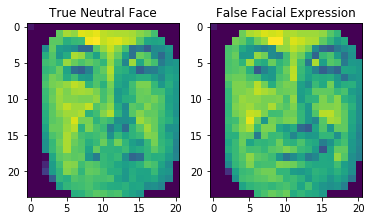

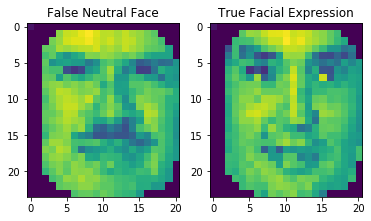

In [31]:
train_acc, train_predicts = best_model.predict_acc(train, train_label)
print("Accuracy on all train data: ", train_acc)

## Create truth table
nf_train_acc, nf_train_predicts = best_model.predict_acc(nf_train, nf_train_label)
nf_train_correct = np.sum(nf_train_predicts==nf_train_label)
nf_train_error = nf_train.shape[0] - nf_train_correct

fe_train_acc, fe_train_predicts = best_model.predict_acc(fe_train, fe_train_label)
fe_train_correct = np.sum(fe_train_predicts==fe_train_label)
fe_train_error = fe_train.shape[0] - fe_train_correct

train_acc_table = np.array([[nf_train_correct, fe_train_error], 
                            [nf_train_error, fe_train_correct]])
train_acc_df = pd.DataFrame(train_acc_table, columns = ['Neutral Face','Facial Expression'])
train_acc_df = train_acc_df.rename(index={0:'Predict 0', 1:'Predict 1'})
display(train_acc_df)

## Calculate false example
nf_train_correct_idxs = np.where(np.array(nf_train_predicts) > 0)[0]
nf_train_error_idxs = np.where(np.array(nf_train_predicts) <= 0)[0]
fe_train_correct_idxs = np.where(np.array(fe_train_predicts) > 0)[0]
fe_train_error_idxs = np.where(np.array(fe_train_predicts) <= 0)[0]
      
print("")
print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_train[nf_train_correct_idxs[0]].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_train[fe_train_error_idxs[0]].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax.set_title('False Neutral Face')
plt.imshow(nf_train[nf_train_error_idxs[0]].reshape((24, 21)))

ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_train[fe_train_correct_idxs[0]].reshape((24, 21)))

Accuracy on all test data:  0.9


,Neutral Face,Facial Expression
Predict 0,39,7
Predict 1,1,33



Example images


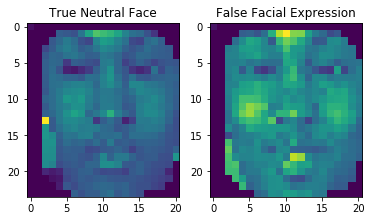

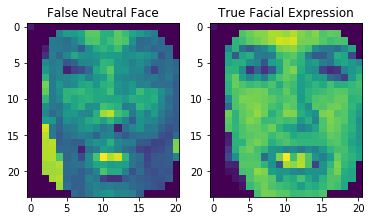

In [32]:
test_acc, test_predicts = best_model.predict_acc(test, test_label)
print("Accuracy on all test data: ", test_acc)

## Create truth table
nf_test_acc, nf_test_predicts = best_model.predict_acc(nf_test, nf_test_label)
nf_test_correct = np.sum(nf_test_predicts==nf_test_label)
nf_test_error = nf_test.shape[0] - nf_test_correct

fe_test_acc, fe_test_predicts = best_model.predict_acc(fe_test, fe_test_label)
fe_test_correct = np.sum(fe_test_predicts==fe_test_label)
fe_test_error = fe_test.shape[0] - fe_test_correct

test_acc_table = np.array([[nf_test_correct, fe_test_error], 
                            [nf_test_error, fe_test_correct]])
test_acc_df = pd.DataFrame(test_acc_table, columns = ['Neutral Face','Facial Expression'])
test_acc_df = test_acc_df.rename(index={0:'Predict 0', 1:'Predict 1'})
display(test_acc_df)

## Calculate false example
nf_test_correct_idxs = np.where(np.array(nf_test_predicts) > 0)[0]
nf_test_error_idxs = np.where(np.array(nf_test_predicts) <= 0)[0]
fe_test_correct_idxs = np.where(np.array(fe_test_predicts) > 0)[0]
fe_test_error_idxs = np.where(np.array(fe_test_predicts) <= 0)[0]
      
print("")
print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_test[nf_test_correct_idxs[0]].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_test[fe_test_error_idxs[0]].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax.set_title('False Neutral Face')
plt.imshow(nf_test[nf_test_error_idxs[0]].reshape((24, 21)))

ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_test[fe_test_correct_idxs[0]].reshape((24, 21)))

### Polynomial kernel

In [33]:
class Poly_SVM_Model:
    def __init__(self, train_data, train_labels, gamma=3, d=1, r=0):
        """
        train_data has shape (N, D) 
        where N is the number of data
        and D is the dimension of feature
        
        train_labels is the label of train data and
        has shape (N,).
    
        gamma is the power parameter in polynomical kernel
        d is the threshold or margin in hinge loss
        """ 
        self.train_data = train_data
        self.train_labels = train_labels
        self.param = {}
        self.param["gamma"] = gamma
        self.param["margin"] = d
        self.param["regularization_strength"] = r
        
        N, D = self.train_data.shape
        self.W = np.random.normal(0, 1, (N, 1))
        self.b = 0
        
    def kernel(self, x):
        """
        x is a feature vector of shape (D,)
        """
        gamma = self.param["gamma"]
        N, D = self.train_data.shape
        base = self.train_data.dot(x.reshape((-1, 1))) + 1
        kernel_vec = (base**gamma).flatten()
        return kernel_vec / (D**gamma)
    
    def predict(self, x):
        """
        x is a feature vector of shape (D,)
        """
        return self.b + self.kernel(x).dot(self.W)
        
    def loss(self, data=None, labels=None):
        if data is None:
            data = self.train_data
            labels = self.train_labels
            
        d = self.param["margin"]
        r = self.param["regularization_strength"]
        loss_value = 0
        for i in range(data.shape[0]):
            yf = labels[i] * self.predict(data[i])
            loss_value += max(0, d-yf[0])
            
        loss_value /= data.shape[0]
        loss_value += r * 0.5 * np.linalg.norm(self.W)
        return loss_value
    
    def train(self, epoch=1, lr=1e-2):
        d = self.param["margin"]
        r = self.param["regularization_strength"]
        labels = self.train_labels
        grad_W = np.zeros((self.W.shape[0],))
        grad_b = 0
        first_moment = grad_W
        second_moment = grad_W
        beta1 = 0.9
        beta2 = 0.99
        for n in range(epoch):
            for i in range(self.train_data.shape[0]):  
                x = self.train_data[i]
                yf = labels[i] * self.predict(x)
                if yf < d:
                    grad_W += -1 * labels[i] * self.kernel(x)
                    grad_b += labels[i] * 1 
                
                grad_W += r * self.W.flatten() 
                
                #first_moment = beta1 * first_moment + (1-beta1) * grad_W
                #second_moment = beta2 * second_moment + (1-beta2) * grad_W**2
                #update = first_moment / (np.sqrt(second_moment) + 1e-7)
                
                self.W -= lr * grad_W.reshape((-1, 1))
                #self.W -= lr *  update.reshape((-1, 1))
                self.b -= lr * grad_b
                grad_W = np.zeros((self.W.shape[0],))
                grad_b = 0
            
            if n % 50 == 0:
                print("Epoch {}, loss={}".format(n, self.loss()))
                
    def predict_acc(self, data, labels):
        predicts = []
        for i in range(data.shape[0]):
            p = self.predict(data[i])
            if p > 0:
                predicts.append(1)
            else :
                predicts.append(-1)
        
        correct = np.sum(predicts==labels)
        accuracy = correct / data.shape[0]
        return accuracy, predicts

In [34]:
poly_svm_model = Poly_SVM_Model(train, train_label, gamma=1)
poly_svm_model.train(epoch=200, lr=1e-5)

Epoch 0, loss=14.323424247875725
Epoch 50, loss=5.0801506348005425
Epoch 100, loss=0.861921408397885
Epoch 150, loss=0.8608275860141639


In [35]:
acc, predicts = poly_svm_model.predict_acc(train, train_label)
print("Train accuracy: ", acc)

Train accuracy:  0.659375


In [36]:
acc, predicts = poly_svm_model.predict_acc(test, test_label)
print("Test accuracy: ", acc)

Test accuracy:  0.6375


#### Cross validate to find best gamma

In [37]:
%%time
gammas = [1, 2, 3]

best_model = None
best_acc = 0
for g in gammas:
    print("Gamma = ", g)
    poly_svm_model = Poly_SVM_Model(train_small, train_small_label, gamma=g)
    poly_svm_model.train(epoch=1000, lr=1e-5)
    acc, predicts = poly_svm_model.predict_acc(val, val_label)
    print("Accuracy: ", acc)
    if acc > best_acc:
        best_acc = acc
        best_model = poly_svm_model

Gamma =  1
Epoch 0, loss=4.343978073760079
Epoch 50, loss=0.8012965495839146
Epoch 100, loss=0.7996621638396123
Epoch 150, loss=0.7982358902390528
Epoch 200, loss=0.7967444470898968
Epoch 250, loss=0.7952204191664426
Epoch 300, loss=0.7936963912429874
Epoch 350, loss=0.7921723633195323
Epoch 400, loss=0.7906537339235147
Epoch 450, loss=0.789179295126747
Epoch 500, loss=0.7876649757452512
Epoch 550, loss=0.7861615410066435
Epoch 600, loss=0.7846770617629227
Epoch 650, loss=0.7832188071863126
Epoch 700, loss=0.7817784351869377
Epoch 750, loss=0.7803314076404839
Epoch 800, loss=0.7788666463281375
Epoch 850, loss=0.777218551696817
Epoch 900, loss=0.7756279551915389
Epoch 950, loss=0.7740046376197923
Accuracy:  0.625
Gamma =  2
Epoch 0, loss=6.633935457182441
Epoch 50, loss=2.0763238719569665
Epoch 100, loss=1.3774221662017117
Epoch 150, loss=1.3683858841877876
Epoch 200, loss=1.3614565281493438
Epoch 250, loss=1.3549711294984526
Epoch 300, loss=1.3493882931861958
Epoch 350, loss=1.34405364

In [38]:
# Train the best model on full train data with gamma=2
best_poly_model = Poly_SVM_Model(train, train_label, gamma=2)
best_poly_model.train(epoch=1000, lr=1e-5)

Epoch 0, loss=3.33552281988367
Epoch 50, loss=0.9136137624981122
Epoch 100, loss=0.9083182400549046
Epoch 150, loss=0.902899354562509
Epoch 200, loss=0.8973219899800062
Epoch 250, loss=0.8920508871761182
Epoch 300, loss=0.8866627952727202
Epoch 350, loss=0.8812789737829956
Epoch 400, loss=0.8758951522932726
Epoch 450, loss=0.8705563212640938
Epoch 500, loss=0.8652526401273486
Epoch 550, loss=0.8599764165919408
Epoch 600, loss=0.8547683182388186
Epoch 650, loss=0.8494920947034128
Epoch 700, loss=0.8443009629482466
Epoch 750, loss=0.8392215913114358
Epoch 800, loss=0.8343998114077197
Epoch 850, loss=0.828865157017556
Epoch 900, loss=0.8237840350621818
Epoch 950, loss=0.8189012252515656


Train accuracy:  0.61875


,Neutral Face,Facial Expression
Predict 0,105,67
Predict 1,55,93



Example images


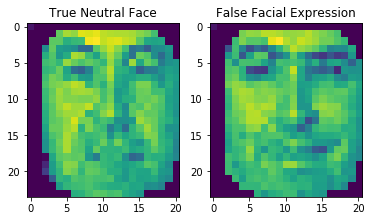

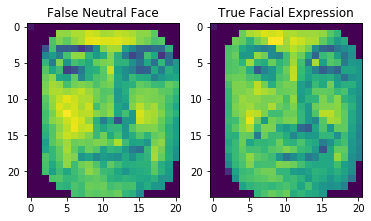

In [39]:
acc, predicts = best_poly_model.predict_acc(train, train_label)
print("Train accuracy: ", acc)

## Create truth table
nf_train_acc, nf_train_predicts = best_poly_model.predict_acc(nf_train, nf_train_label)
nf_train_correct = np.sum(nf_train_predicts==nf_train_label)
nf_train_error = nf_train.shape[0] - nf_train_correct

fe_train_acc, fe_train_predicts = best_poly_model.predict_acc(fe_train, fe_train_label)
fe_train_correct = np.sum(fe_train_predicts==fe_train_label)
fe_train_error = fe_train.shape[0] - fe_train_correct

train_acc_table = np.array([[nf_train_correct, fe_train_error], 
                            [nf_train_error, fe_train_correct]])
train_acc_df = pd.DataFrame(train_acc_table, columns = ['Neutral Face','Facial Expression'])
train_acc_df = train_acc_df.rename(index={0:'Predict 0', 1:'Predict 1'})
display(train_acc_df)

## Calculate false example
nf_train_correct_idxs = np.where(np.array(nf_train_predicts) > 0)[0]
nf_train_error_idxs = np.where(np.array(nf_train_predicts) <= 0)[0]
fe_train_correct_idxs = np.where(np.array(fe_train_predicts) > 0)[0]
fe_train_error_idxs = np.where(np.array(fe_train_predicts) <= 0)[0]
      
print("")
print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_train[nf_train_correct_idxs[0]].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_train[fe_train_error_idxs[0]].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax.set_title('False Neutral Face')
plt.imshow(nf_train[nf_train_error_idxs[0]].reshape((24, 21)))

ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_train[fe_train_correct_idxs[0]].reshape((24, 21)))

Test accuracy:  0.6125


,Neutral Face,Facial Expression
Predict 0,28,19
Predict 1,12,21



Example images


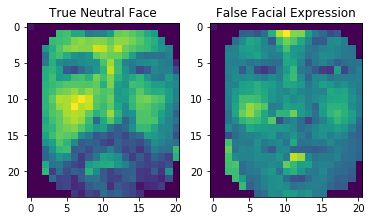

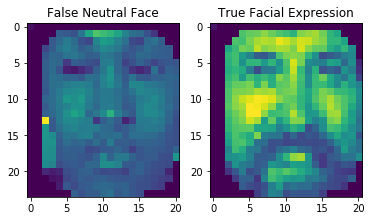

In [40]:
acc, predicts = best_poly_model.predict_acc(test, test_label)
print("Test accuracy: ", acc)

## Create truth table
nf_test_acc, nf_test_predicts = best_poly_model.predict_acc(nf_test, nf_test_label)
nf_test_correct = np.sum(nf_test_predicts==nf_test_label)
nf_test_error = nf_test.shape[0] - nf_test_correct

fe_test_acc, fe_test_predicts = best_poly_model.predict_acc(fe_test, fe_test_label)
fe_test_correct = np.sum(fe_test_predicts==fe_test_label)
fe_test_error = fe_test.shape[0] - fe_test_correct

test_acc_table = np.array([[nf_test_correct, fe_test_error], 
                            [nf_test_error, fe_test_correct]])
test_acc_df = pd.DataFrame(test_acc_table, columns = ['Neutral Face','Facial Expression'])
test_acc_df = test_acc_df.rename(index={0:'Predict 0', 1:'Predict 1'})
display(test_acc_df)

## Calculate false example
nf_test_correct_idxs = np.where(np.array(nf_test_predicts) > 0)[0]
nf_test_error_idxs = np.where(np.array(nf_test_predicts) <= 0)[0]
fe_test_correct_idxs = np.where(np.array(fe_test_predicts) > 0)[0]
fe_test_error_idxs = np.where(np.array(fe_test_predicts) <= 0)[0]
      
print("")
print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_test[nf_test_correct_idxs[0]].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_test[fe_test_error_idxs[0]].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax.set_title('False Neutral Face')
plt.imshow(nf_test[nf_test_error_idxs[0]].reshape((24, 21)))

ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_test[fe_test_correct_idxs[0]].reshape((24, 21)))

## Boosted SVM

In [41]:
# Linear SVM without boosting
linear_svm_model = Poly_SVM_Model(train, train_label, gamma=1)
linear_svm_model.train(epoch=1000, lr=1e-5)

Epoch 0, loss=8.348000948255228
Epoch 50, loss=1.006180970707112
Epoch 100, loss=0.9955569887783107
Epoch 150, loss=0.9924028478424397
Epoch 200, loss=0.9893298973795286
Epoch 250, loss=0.9869554395294188
Epoch 300, loss=0.9845291419830439
Epoch 350, loss=0.9821814433428484
Epoch 400, loss=0.9797750848998905
Epoch 450, loss=0.9774273862596956
Epoch 500, loss=0.9750796876194976
Epoch 550, loss=0.9726733291765379
Epoch 600, loss=0.970327504256813
Epoch 650, loss=0.9680018442031658
Epoch 700, loss=0.9656761841495195
Epoch 750, loss=0.963350524095873
Epoch 800, loss=0.9611003654192279
Epoch 850, loss=0.9587951206607912
Epoch 900, loss=0.9564898759023561
Epoch 950, loss=0.954184631143921


In [42]:
acc, predicts = linear_svm_model.predict_acc(train, train_label)
print("Train accuracy: ", acc)
acc, predicts = linear_svm_model.predict_acc(test, test_label)
print("Test accuracy: ", acc)

Train accuracy:  0.58125
Test accuracy:  0.5875


In [43]:
def adaBoost(train_data, train_label, iteration=5):
    N, D = train.shape
    w = np.ones((N)) * 1/N
    idxs = np.arange(N)

    models = []
    model_weights = []
    for i in range(iteration):
        print("Iteration: ", i)
        # Sample train data
        sample_idxs = np.random.choice(idxs, N, p=w)
        curr_train = train_data[sample_idxs, :]
        curr_label = train_label[sample_idxs]
    
        # Create weak classifier
        weak_learner = Poly_SVM_Model(curr_train, curr_label, gamma=1)
        weak_learner.train(epoch=1000, lr=1e-5)
    
        # Do prediction
        acc, predicts = weak_learner.predict_acc(train_data, train_label)
        print("weak learner acc: ", acc)
        error_rate = 1 - acc
        correct_idx = np.where(np.array(predicts)==train_label)
        error_idx = np.where(np.array(predicts)!=train_label)
    
        # Calculate weight for weak learner
        model_weight = 0.5 * np.log(acc / error_rate)
    
        # Update weights for data
        w[correct_idx] *= np.exp(-model_weight)
        w[error_idx] *= np.exp(model_weight)
        w = w / np.sum(w)
    
        model_weights.append(model_weight)
        models.append(weak_learner)
    
    return models, model_weights

In [44]:
def adaBoost_model(models, model_weights, data, labels, use_iter=-1):
    if use_iter==-1:
        # use full iteration
        use_iter = len(models)
        
    N, D = data.shape
    weighted_predicts = np.zeros((N,))
    for i in range(use_iter):
        _, predicts = models[i].predict_acc(data, labels)
        weighted_predicts += model_weights[i] * np.array(predicts)
        
    weighted_predicts[weighted_predicts > 0] = 1
    weighted_predicts[weighted_predicts <= 0] = -1
        
    correct = np.sum(weighted_predicts==labels)
    accuracy = correct / data.shape[0]
    return accuracy, weighted_predicts

In [45]:
models, model_weights = adaBoost(train_data=train, train_label=train_label, iteration=10)

Iteration:  0
Epoch 0, loss=10.897256679431582
Epoch 50, loss=1.857666534165031
Epoch 100, loss=1.0199082233216097
Epoch 150, loss=1.0172667822177701
Epoch 200, loss=1.0148682733882854
Epoch 250, loss=1.0126564783287153
Epoch 300, loss=1.010458869238334
Epoch 350, loss=1.008262550165916
Epoch 400, loss=1.00606966893455
Epoch 450, loss=1.0038823757747994
Epoch 500, loss=1.001695082615047
Epoch 550, loss=0.9995067143400155
Epoch 600, loss=0.9973194211802646
Epoch 650, loss=0.9951310529052314
Epoch 700, loss=0.9929437597454791
Epoch 750, loss=0.9907564665857274
Epoch 800, loss=0.9885680983106939
Epoch 850, loss=0.9863808051509408
Epoch 900, loss=0.9841935119911902
Epoch 950, loss=0.9820051437161569
weak learner acc:  0.5625
Iteration:  1
Epoch 0, loss=1.3410012935586884
Epoch 50, loss=0.8723240666379501
Epoch 100, loss=0.8697343988147377
Epoch 150, loss=0.8670047897655818
Epoch 200, loss=0.8642606104016128
Epoch 250, loss=0.8615381986793237
Epoch 300, loss=0.8587950681798304
Epoch 350, lo

In [46]:
acc, predicts = adaBoost_model(models, model_weights, train, train_label, use_iter=2)
print("AdaBoost linear SVM accuracy: ", acc)
acc, predicts = adaBoost_model(models, model_weights, test, test_label, use_iter=2)
print("Test accuracy: ", acc)

AdaBoost linear SVM accuracy:  0.5625
Test accuracy:  0.4625


In [47]:
acc, predicts = adaBoost_model(models, model_weights, train, train_label, use_iter=5)
print("AdaBoost linear SVM accuracy: ", acc)
acc, predicts = adaBoost_model(models, model_weights, test, test_label, use_iter=5)
print("Test accuracy: ", acc)

AdaBoost linear SVM accuracy:  0.55625
Test accuracy:  0.525


In [48]:
acc, predicts = adaBoost_model(models, model_weights, train, train_label, use_iter=10)
print("AdaBoost linear SVM accuracy: ", acc)
acc, predicts = adaBoost_model(models, model_weights, test, test_label, use_iter=10)
print("Test accuracy: ", acc)

AdaBoost linear SVM accuracy:  0.63125
Test accuracy:  0.5625


## Principal component analysis (PCA)

In [49]:
def PCA(data, reduced_dim=10):
    data_cov = np.cov(data.T)
    eigvalues, eigvectors = np.linalg.eig(data_cov)
    return eigvectors[:, :reduced_dim]

def apply_PCA(data, eigvectors):
    reduced_data = data.dot(eigvectors)
    return reduced_data

In [50]:
# apply PCA
eigvec = PCA(train)
reduced_train = apply_PCA(train, eigvec)
print("reduced train data shape: ", reduced_train.shape)

reduced_nf_train = reduced_train[:nf_train.shape[0], :]
reduced_fe_train = reduced_train[nf_train.shape[0]:, :]

reduced_nf_test = apply_PCA(nf_test, eigvec)
reduced_fe_test = apply_PCA(fe_test, eigvec)
reduced_test = apply_PCA(test, eigvec)

reduced train data shape:  (320, 10)


### Bayesian Classifier (with PCA)

In [51]:
# train data and labels
N, D = nf_train.shape
nf_train_label = np.zeros(N) 
N, D = nf_test.shape
nf_test_label = np.zeros(N) 

N, D = fe_train.shape
fe_train_label = np.ones(N) 
N, D = fe_test.shape
fe_test_label = np.ones(N) 

train = np.vstack((nf_train, fe_train))
test = np.vstack((nf_test, fe_test))
train_label = np.hstack((nf_train_label, fe_train_label))
test_label = np.hstack((nf_test_label, fe_test_label))

In [52]:
## ML estimate of mean and covarinace matrix
reduced_nf_mean = np.mean(reduced_nf_train, axis=0)
print("reduced nf mean shape: ", reduced_nf_mean.shape)
reduced_nf_cov = np.cov(reduced_nf_train.T)
print("reduced nf cov shape: ", reduced_nf_cov.shape)

reduced_fe_mean = np.mean(reduced_fe_train, axis=0)
print("reduced fe mean shape: ", reduced_fe_mean.shape)
reduced_fe_cov = np.cov(reduced_fe_train.T)
print("reduced fe cov shape: ", reduced_fe_cov.shape)

reduced nf mean shape:  (10,)
reduced nf cov shape:  (10, 10)
reduced fe mean shape:  (10,)
reduced fe cov shape:  (10, 10)


In [53]:
# Likelihood (Gaussian)
reduced_nf_ml_likelihood = lambda x: multivariate_normal.pdf(x, reduced_nf_mean, reduced_nf_cov, True)
reduced_fe_ml_likelihood = lambda x: multivariate_normal.pdf(x, reduced_fe_mean, reduced_fe_cov, True)

# Prior
nf_prior = (nf_train.shape[0]) / train.shape[0]
fe_prior = (fe_train.shape[0]) / train.shape[0]

# Posterior 
reduced_nf_posterior = lambda x: reduced_nf_ml_likelihood(x) * nf_prior
reduced_fe_posterior = lambda x: reduced_fe_ml_likelihood(x) * fe_prior

In [54]:
%%time
# Train Evaluation
nf_train_correct, nf_train_correct_idxs = bayes_classifier(reduced_nf_train, 0, reduced_nf_posterior, reduced_fe_posterior)
nf_train_error = nf_train.shape[0] - nf_train_correct
fe_train_correct, fe_train_correct_idxs = bayes_classifier(reduced_fe_train, 1, reduced_nf_posterior, reduced_fe_posterior)
fe_train_error = fe_train.shape[0] - fe_train_correct

CPU times: user 209 ms, sys: 328 ms, total: 538 ms
Wall time: 77.1 ms


/home/longhongc/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py:381: ComplexWarning: Casting complex values to real discards the imaginary part
  mean = np.asarray(mean, dtype=float)
/home/longhongc/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py:396: ComplexWarning: Casting complex values to real discards the imaginary part
  cov = np.asarray(cov, dtype=float)
/home/longhongc/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py:430: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.asarray(x, dtype=float)


Total train accuracy:  0.85


,Neutral Face,Facial Expression
Predict 0,150,38
Predict 1,10,122


,Neutral Face,Facial Expression
Precision,0.9375,0.7625



Example images


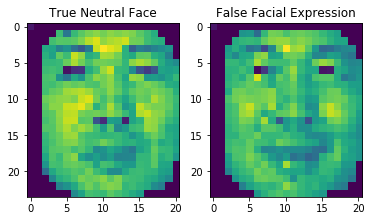

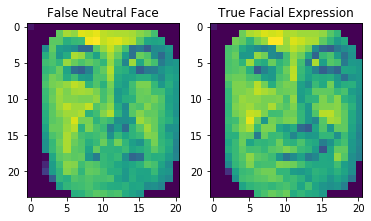

In [55]:
# Train accuracy
print("Total train accuracy: ", (nf_train_correct + fe_train_correct) / train.shape[0])

## Create truth table
train_acc_table = np.array([[nf_train_correct, fe_train_error], 
                            [nf_train_error, fe_train_correct]])
train_acc_df = pd.DataFrame(train_acc_table, columns = ['Neutral Face','Facial Expression'])
train_acc_df = train_acc_df.rename(index={0:'Predict 0', 1:'Predict 1'})
display(train_acc_df)

nf_precision = nf_train_correct / nf_train.shape[0]
fe_precision = fe_train_correct / fe_train.shape[0]
precision_table = np.array([[nf_precision, fe_precision]])
precision_df = pd.DataFrame(precision_table, columns = ['Neutral Face','Facial Expression'])
precision_df = precision_df.rename(index={0:'Precision'})
display(precision_df)

## Calculate false example
nf_train_correct_idxs_set = set(nf_train_correct_idxs)
nf_error_idx = -1
for i in range(nf_train.shape[0]):
    if not i in nf_train_correct_idxs_set:
        nf_error_idx = i
        break

fe_train_correct_idxs_set = set(fe_train_correct_idxs)
fe_error_idx = -1
for i in range(fe_train.shape[0]):
    if not i in fe_train_correct_idxs_set:
        fe_error_idx = i
        break
      
print("")
print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_train[nf_train_correct_idxs[0]].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_train[fe_error_idx].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax.set_title('False Neutral Face')
plt.imshow(nf_train[nf_error_idx].reshape((24, 21)))

ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_train[fe_train_correct_idxs[0]].reshape((24, 21)))

In [56]:
%%time
# Test Evaluation
nf_test_correct, nf_test_correct_idxs = bayes_classifier(reduced_nf_test, 0, reduced_nf_posterior, reduced_fe_posterior)
nf_test_error = nf_test.shape[0] - nf_test_correct
fe_test_correct, fe_test_correct_idxs = bayes_classifier(reduced_fe_test, 1, reduced_nf_posterior, reduced_fe_posterior)
fe_test_error = fe_test.shape[0] - fe_test_correct

CPU times: user 23.9 ms, sys: 21.9 ms, total: 45.8 ms
Wall time: 14.7 ms


/home/longhongc/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py:381: ComplexWarning: Casting complex values to real discards the imaginary part
  mean = np.asarray(mean, dtype=float)
/home/longhongc/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py:396: ComplexWarning: Casting complex values to real discards the imaginary part
  cov = np.asarray(cov, dtype=float)
/home/longhongc/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py:430: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.asarray(x, dtype=float)


Test accuracy
Total test accuracy:  0.8


,Neutral Face,Facial Expression
Predict 0,38,14
Predict 1,2,26


,Neutral Face,Facial Expression
Precision,0.95,0.65



Example images


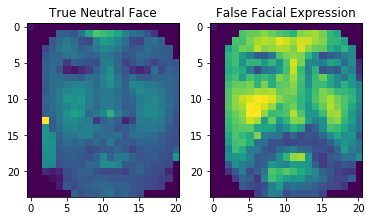

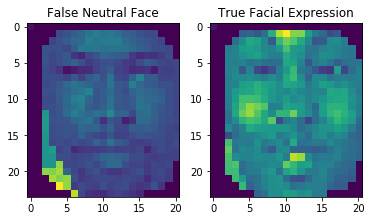

In [57]:
# Test accuracy
print("Test accuracy")
print("Total test accuracy: ", (nf_test_correct + fe_test_correct) / test.shape[0])

test_acc_table = np.array([[nf_test_correct, fe_test_error], 
                            [nf_test_error, fe_test_correct]])
test_acc_df = pd.DataFrame(test_acc_table, columns = ['Neutral Face','Facial Expression'])
test_acc_df = test_acc_df.rename(index={0: 'Predict 0', 1:'Predict 1'})
display(test_acc_df)

nf_precision = nf_test_correct / nf_test.shape[0]
fe_precision = fe_test_correct / fe_test.shape[0]
precision_table = np.array([[nf_precision, fe_precision]])
precision_df = pd.DataFrame(precision_table, columns = ['Neutral Face','Facial Expression'])
precision_df = precision_df.rename(index={0:'Precision'})
display(precision_df)

## Calculate false example
nf_test_correct_idxs_set = set(nf_test_correct_idxs)
nf_error_idx = -1
for i in range(nf_test.shape[0]):
    if not i in nf_test_correct_idxs_set:
        nf_error_idx = i
        break

fe_test_correct_idxs_set = set(fe_test_correct_idxs)
fe_error_idx = -1
for i in range(fe_test.shape[0]):
    if not i in fe_test_correct_idxs_set:
        fe_error_idx = i
        break
      
print("")
print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_test[nf_test_correct_idxs[0]].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_test[fe_error_idx].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax.set_title('False Neutral Face')
plt.imshow(nf_test[nf_error_idx].reshape((24, 21)))

ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_test[fe_test_correct_idxs[0]].reshape((24, 21)))

### K Nearest Neighbor (with PCA)

#### K=1

In [58]:
%%time
# Train Evaluation
train_predict = knn(train_data=reduced_train, train_label=train_label, target=reduced_train)
train_correct = np.sum(train_predict==train_label)
print("Total train accuracy: ", train_correct / train_label.shape[0])

Total train accuracy:  1.0
CPU times: user 11.4 ms, sys: 4.29 ms, total: 15.7 ms
Wall time: 13.3 ms


Total test accuracy:  0.8125


,Neutral Face,Facial Expression
Predict 0,35,10
Predict 1,5,30


,Neutral Face,Facial Expression
Precision,0.875,0.75


Example images
CPU times: user 33.5 ms, sys: 4.01 ms, total: 37.5 ms
Wall time: 33.9 ms


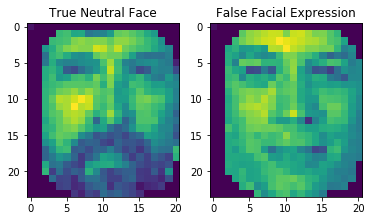

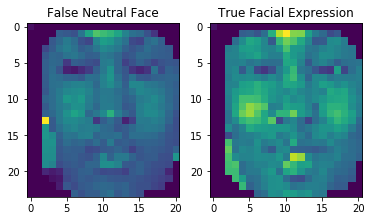

In [59]:
%%time
# Test Evaluation
test_predict = knn(train_data=reduced_train, train_label=train_label, target=reduced_test)
test_correct = np.sum(test_predict==test_label)
print("Total test accuracy: ", test_correct / test_label.shape[0])


## Create truth table
nf_test_predict = knn(train_data=reduced_train, train_label=train_label, target=reduced_nf_test)
nf_test_correct = np.sum(nf_test_predict==nf_test_label)
nf_test_error = nf_test.shape[0] - nf_test_correct

fe_test_predict = knn(train_data=reduced_train, train_label=train_label, target=reduced_fe_test)
fe_test_correct = np.sum(fe_test_predict==fe_test_label)
fe_test_error = fe_test.shape[0] - fe_test_correct

test_acc_table = np.array([[nf_test_correct, fe_test_error], 
                            [nf_test_error, fe_test_correct]])
test_acc_df = pd.DataFrame(test_acc_table, columns = ['Neutral Face','Facial Expression'])
test_acc_df = test_acc_df.rename(index={0: 'Predict 0', 1:'Predict 1'})
display(test_acc_df)

## Calculate precision
nf_precision = nf_test_correct / nf_test.shape[0]
fe_precision = fe_test_correct / fe_test.shape[0]
precision_table = np.array([[nf_precision, fe_precision]])
precision_df = pd.DataFrame(precision_table, columns = ['Neutral Face','Facial Expression'])
precision_df = precision_df.rename(index={0:'Precision'})
display(precision_df)

## Correct and error prediction images 
nf_correct_predict = nf_test[np.where(nf_test_predict==nf_test_label)]
nf_error_predict = nf_test[np.where(nf_test_predict!=nf_test_label)]
fe_correct_predict = fe_test[np.where(fe_test_predict==fe_test_label)]
fe_error_predict = fe_test[np.where(fe_test_predict!=fe_test_label)]

print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_correct_predict[0].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_error_predict[0].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax.set_title('False Neutral Face')
plt.imshow(nf_error_predict[0].reshape((24, 21)))

ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_correct_predict[0].reshape((24, 21)))

#### K=3

In [60]:
%%time
# Train Evaluation
train_predict = knn(train_data=reduced_train, train_label=train_label, target=reduced_train, k=3)
train_correct = np.sum(train_predict==train_label)
print("Total train accuracy: ", train_correct / train_label.shape[0])

Total train accuracy:  0.828125
CPU times: user 11.1 ms, sys: 3.39 ms, total: 14.5 ms
Wall time: 12.4 ms


Total test accuracy:  0.8125


,Neutral Face,Facial Expression
Predict 0,36,11
Predict 1,4,29


,Neutral Face,Facial Expression
Precision,0.9,0.725


Example images
CPU times: user 31.2 ms, sys: 5.47 ms, total: 36.6 ms
Wall time: 32.2 ms


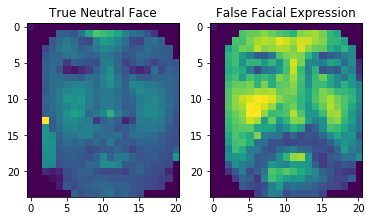

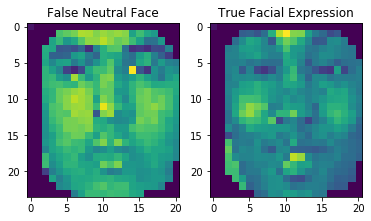

In [61]:
%%time
# Test Evaluation
test_predict = knn(train_data=reduced_train, train_label=train_label, target=reduced_test, k=3)
test_correct = np.sum(test_predict==test_label)
print("Total test accuracy: ", test_correct / test_label.shape[0])


## Create truth table
nf_test_predict = knn(train_data=reduced_train, train_label=train_label, target=reduced_nf_test, k=3)
nf_test_correct = np.sum(nf_test_predict==nf_test_label)
nf_test_error = nf_test.shape[0] - nf_test_correct

fe_test_predict = knn(train_data=reduced_train, train_label=train_label, target=reduced_fe_test, k=3)
fe_test_correct = np.sum(fe_test_predict==fe_test_label)
fe_test_error = fe_test.shape[0] - fe_test_correct

test_acc_table = np.array([[nf_test_correct, fe_test_error], 
                            [nf_test_error, fe_test_correct]])
test_acc_df = pd.DataFrame(test_acc_table, columns = ['Neutral Face','Facial Expression'])
test_acc_df = test_acc_df.rename(index={0: 'Predict 0', 1:'Predict 1'})
display(test_acc_df)

## Calculate precision
nf_precision = nf_test_correct / nf_test.shape[0]
fe_precision = fe_test_correct / fe_test.shape[0]
precision_table = np.array([[nf_precision, fe_precision]])
precision_df = pd.DataFrame(precision_table, columns = ['Neutral Face','Facial Expression'])
precision_df = precision_df.rename(index={0:'Precision'})
display(precision_df)

## Correct and error prediction images 
nf_correct_predict = nf_test[np.where(nf_test_predict==nf_test_label)]
nf_error_predict = nf_test[np.where(nf_test_predict!=nf_test_label)]
fe_correct_predict = fe_test[np.where(fe_test_predict==fe_test_label)]
fe_error_predict = fe_test[np.where(fe_test_predict!=fe_test_label)]

print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_correct_predict[0].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_error_predict[0].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax.set_title('False Neutral Face')
plt.imshow(nf_error_predict[0].reshape((24, 21)))

ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_correct_predict[0].reshape((24, 21)))

### Kernel SVM (with PCA)

In [62]:
# Define neutral face with label 1
# Define facial expression with label -1
N, D = nf_train.shape
nf_train_label = np.ones(N) 
N, D = nf_test.shape
nf_test_label = np.ones(N) 

N, D = fe_train.shape
fe_train_label = -1 * np.ones(N) 
N, D = fe_test.shape
fe_test_label = -1 * np.ones(N) 

train = np.vstack((nf_train, fe_train))
test = np.vstack((nf_test, fe_test))
train_label = np.hstack((nf_train_label, fe_train_label))
test_label = np.hstack((nf_test_label, fe_test_label))

#### RBF kernel

In [63]:
%%time
rbf_svm_model = RBF_SVM_Model(reduced_train, train_label, sig=3, r=0.01)
rbf_svm_model.train(epoch=1000, lr=5e-4)

Epoch 0, loss=1.518449696528019
Epoch 50, loss=1.5862260096293022
Epoch 100, loss=1.102561098543575
Epoch 150, loss=0.7898106132142144
Epoch 200, loss=0.6292975034633748
Epoch 250, loss=0.617640597261966
Epoch 300, loss=0.5166460192300906
Epoch 350, loss=0.49684723880460535
Epoch 400, loss=0.48250448902001525
Epoch 450, loss=0.46686891813477077
Epoch 500, loss=0.4508594541934068
Epoch 550, loss=0.4058867634075495
Epoch 600, loss=0.4004177460565731
Epoch 650, loss=0.39492220580006765
Epoch 700, loss=0.39250444049069283
Epoch 750, loss=0.3910433366991518
Epoch 800, loss=0.3927326616953832
Epoch 850, loss=0.3889123615889481
Epoch 900, loss=0.3910122128494854
Epoch 950, loss=0.38817952428016606
CPU times: user 8.96 s, sys: 14.5 ms, total: 8.98 s
Wall time: 8.96 s


In [64]:
acc, predicts = rbf_svm_model.predict_acc(reduced_train, train_label)
print("Train accuracy: ", acc)

Train accuracy:  0.8875


In [65]:
acc, predicts = rbf_svm_model.predict_acc(reduced_test, test_label)
print("Train accuracy: ", acc)

Train accuracy:  0.8875


In [66]:
%%time
rbf_svm_model = RBF_SVM_Model(reduced_train, train_label, sig=2, r=0.01)
rbf_svm_model.train(epoch=1000, lr=5e-5)

Epoch 0, loss=2.658619792908488
Epoch 50, loss=1.2842553632114473
Epoch 100, loss=0.8727251672463521
Epoch 150, loss=0.8412658572189438
Epoch 200, loss=0.8273872198855383
Epoch 250, loss=0.815087841930352
Epoch 300, loss=0.8041461473400299
Epoch 350, loss=0.7943800193709828
Epoch 400, loss=0.7849074007196427
Epoch 450, loss=0.7757718748843975
Epoch 500, loss=0.7669187800452293
Epoch 550, loss=0.7585604943281881
Epoch 600, loss=0.7505070372193061
Epoch 650, loss=0.7426498468476612
Epoch 700, loss=0.7351002202311263
Epoch 750, loss=0.7285070876692528
Epoch 800, loss=0.722100542124454
Epoch 850, loss=0.7159804290153771
Epoch 900, loss=0.7103049448191215
Epoch 950, loss=0.7047520166288653
CPU times: user 10.1 s, sys: 22.7 ms, total: 10.2 s
Wall time: 10.1 s


In [67]:
acc, predicts = rbf_svm_model.predict_acc(reduced_train, train_label)
print("Train accuracy: ", acc)

Train accuracy:  0.765625


In [68]:
acc, predicts = rbf_svm_model.predict_acc(reduced_test, test_label)
print("Train accuracy: ", acc)

Train accuracy:  0.7375


#### Polynomial kernel

In [69]:
reduced_train = reduced_train.astype(float)
poly_svm_model = Poly_SVM_Model(reduced_train, train_label, gamma=1)
poly_svm_model.train(epoch=1000, lr=1e-5)

Epoch 0, loss=18.0641277287623


/tmp/ipykernel_457/3592336119.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  reduced_train = reduced_train.astype(float)


Epoch 50, loss=4.673090289179407
Epoch 100, loss=3.3207544457649667
Epoch 150, loss=2.4749769791767875
Epoch 200, loss=1.9776007875129948
Epoch 250, loss=1.7581573994928745
Epoch 300, loss=1.5194992439263224
Epoch 350, loss=1.3946353239849016
Epoch 400, loss=1.2932567649294653
Epoch 450, loss=1.2019703489686382
Epoch 500, loss=1.1543584174690693
Epoch 550, loss=1.056578646469363
Epoch 600, loss=1.0174439714184302
Epoch 650, loss=0.9627308710749176
Epoch 700, loss=0.9267001767408173
Epoch 750, loss=0.89001424079122
Epoch 800, loss=0.8489536751300075
Epoch 850, loss=0.8102664204594789
Epoch 900, loss=0.7887282977434841
Epoch 950, loss=0.7782625379713873


In [70]:
acc, predicts = poly_svm_model.predict_acc(reduced_train, train_label)
print("Train accuracy: ", acc)

Train accuracy:  0.81875


In [71]:
reduced_test = reduced_test.astype(float)
acc, predicts = poly_svm_model.predict_acc(reduced_test, test_label)
print("Test accuracy: ", acc)

Test accuracy:  0.8875


/tmp/ipykernel_457/3816246340.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  reduced_test = reduced_test.astype(float)


In [72]:
poly_svm_model = Poly_SVM_Model(reduced_train, train_label, gamma=2)
poly_svm_model.train(epoch=1000, lr=1e-6)

Epoch 0, loss=545.5517343016332
Epoch 50, loss=103.20558672576446
Epoch 100, loss=53.83342986624187
Epoch 150, loss=25.548605555720886
Epoch 200, loss=16.599132892656897
Epoch 250, loss=12.010881911591293
Epoch 300, loss=10.195454135362478
Epoch 350, loss=9.292758084113073
Epoch 400, loss=8.766561606491006
Epoch 450, loss=8.305488799206405
Epoch 500, loss=8.012991032898208
Epoch 550, loss=7.752792546676538
Epoch 600, loss=7.506330088620466
Epoch 650, loss=7.328847953463152
Epoch 700, loss=7.163450076437371
Epoch 750, loss=6.964588110504543
Epoch 800, loss=6.830077726023591
Epoch 850, loss=6.64620016027461
Epoch 900, loss=6.50786253904292
Epoch 950, loss=6.393500472605588


In [73]:
acc, predicts = poly_svm_model.predict_acc(reduced_train, train_label)
print("Train accuracy: ", acc)

Train accuracy:  0.803125


In [74]:
acc, predicts = poly_svm_model.predict_acc(reduced_test, test_label)
print("Test accuracy: ", acc)

Test accuracy:  0.825


In [75]:
poly_svm_model = Poly_SVM_Model(reduced_train, train_label, gamma=3)
poly_svm_model.train(epoch=1000, lr=1e-7)

Epoch 0, loss=2951.980602648832
Epoch 50, loss=705.9198090268045
Epoch 100, loss=566.2837724458666
Epoch 150, loss=479.5505822624788
Epoch 200, loss=421.4953264899153
Epoch 250, loss=380.5453521738918
Epoch 300, loss=347.38850240683684
Epoch 350, loss=319.6867658491672
Epoch 400, loss=301.21701645362384
Epoch 450, loss=282.3455297925842
Epoch 500, loss=266.9202341321883
Epoch 550, loss=251.28151880233145
Epoch 600, loss=238.97675046784656
Epoch 650, loss=227.94350985667157
Epoch 700, loss=218.54552415573698
Epoch 750, loss=210.59320182290898
Epoch 800, loss=202.78994280337852
Epoch 850, loss=195.46444281910027
Epoch 900, loss=189.7041866901107
Epoch 950, loss=184.24937769295377


In [76]:
acc, predicts = poly_svm_model.predict_acc(reduced_train, train_label)
print("Train accuracy: ", acc)

Train accuracy:  0.7875


In [77]:
acc, predicts = poly_svm_model.predict_acc(reduced_test, test_label)
print("Test accuracy: ", acc)

Test accuracy:  0.7375


### Boosted SVM (with PCA)

In [78]:
models, model_weights = adaBoost(train_data=reduced_train, train_label=train_label, iteration=10)

Iteration:  0
Epoch 0, loss=122.01668910853039
Epoch 50, loss=8.689790865100147
Epoch 100, loss=5.84480868052174
Epoch 150, loss=4.353354270920494
Epoch 200, loss=3.4824341919665684
Epoch 250, loss=2.779371144367801
Epoch 300, loss=2.151475723882934
Epoch 350, loss=1.7122105807409909
Epoch 400, loss=1.4111194114997407
Epoch 450, loss=1.2084026404565429
Epoch 500, loss=1.05560519274692
Epoch 550, loss=0.948485029811702
Epoch 600, loss=0.8825837940630636
Epoch 650, loss=0.8231510854540266
Epoch 700, loss=0.77474108717016
Epoch 750, loss=0.7272714017126839
Epoch 800, loss=0.6878401991999987
Epoch 850, loss=0.6518576154280317
Epoch 900, loss=0.6211231695120174
Epoch 950, loss=0.5907092348948163
weak learner acc:  0.86875
Iteration:  1
Epoch 0, loss=14.867598147851329
Epoch 50, loss=4.222059752847651
Epoch 100, loss=2.7863095910123006
Epoch 150, loss=2.089621937200132
Epoch 200, loss=1.7321272391539828
Epoch 250, loss=1.5577503867406426
Epoch 300, loss=1.4303073771206232
Epoch 350, loss=1.2

In [79]:
acc, predicts = adaBoost_model(models, model_weights, reduced_train, train_label)
print("AdaBoost linear SVM accuracy: ", acc)
acc, predicts = adaBoost_model(models, model_weights, reduced_test, test_label)
print("Test accuracy: ", acc)

AdaBoost linear SVM accuracy:  0.8625
Test accuracy:  0.825


## Linear discriminant analysis (LDA)

In [80]:
## ML estimate of mean and covarinace matrix
nf_mean = np.mean(nf_train, axis=0)
print("nf mean shape: ", nf_mean.shape)
nf_cov = np.cov(nf_train.T)
print("nf cov shape: ", nf_cov.shape)

fe_mean = np.mean(fe_train, axis=0)
print("fe mean shape: ", fe_mean.shape)
fe_cov = np.cov(fe_train.T)
print("fe cov shape: ", fe_cov.shape)

nf mean shape:  (504,)
nf cov shape:  (504, 504)
fe mean shape:  (504,)
fe cov shape:  (504, 504)


In [81]:
# Prior
nf_prior = (nf_train.shape[0]) / train.shape[0]
fe_prior = (fe_train.shape[0]) / train.shape[0]

# MDA param
SigmaW = nf_prior * nf_cov + fe_prior * fe_cov
theta = np.linalg.pinv(SigmaW).dot(nf_mean - fe_mean)
print("theta shape: ", theta.shape)

theta shape:  (504,)


In [82]:
def apply_MDA(data, theta):
    """
    data has shape (N, D) 
    where N is the number of data
    and D is the dimension of feature
    
    theta is the projected vector
    """
    projected_data = data.dot(theta.reshape((-1, 1)))
    return projected_data

In [83]:
projected_nf_train = apply_MDA(nf_train, theta=theta) 
projected_fe_train = apply_MDA(fe_train, theta=theta)

print("projected nf_train: ", projected_nf_train[:5])
print("projected fe_train: ", projected_fe_train[:5])

projected nf_train:  [[-34.57581605]
 [-22.19331087]
 [-26.30081353]
 [-19.94087696]
 [-26.74506741]]
projected fe_train:  [[-112.28666095]
 [-113.57367743]
 [-110.29450143]
 [-121.36102451]
 [-103.22249626]]


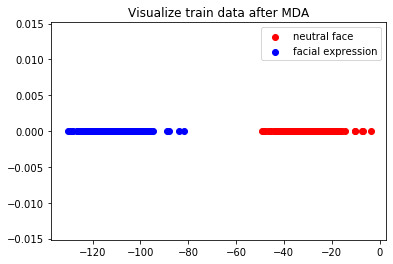

In [84]:
%matplotlib inline
# Visualize data after MDA
fig, ax = plt.subplots()
ax.set_title("Visualize train data after MDA")
projected_nf_y = np.zeros_like(projected_nf_train)
projected_fe_y = np.zeros_like(projected_fe_train)
ax.scatter(projected_nf_train, projected_nf_y, color='r', label='neutral face')
ax.scatter(projected_fe_train, projected_fe_y, color='b', label='facial expression')
ax.legend()

In [85]:
projected_nf_test = apply_MDA(nf_test, theta=theta) 
projected_fe_test = apply_MDA(fe_test, theta=theta)

print("projected nf_train: ", projected_nf_test[:5])
print("projected fe_train: ", projected_fe_test[:5])

projected nf_train:  [[ -84.48315836]
 [  38.89231225]
 [-126.23375876]
 [-101.53921886]
 [   1.48216971]]
projected fe_train:  [[-106.43121572]
 [ -76.35262411]
 [  14.00550854]
 [-144.58912078]
 [-171.46866019]]


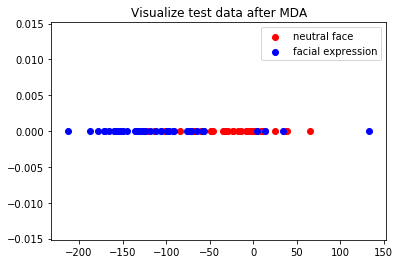

In [86]:
%matplotlib inline
# Visualize data after MDA
fig, ax = plt.subplots()
ax.set_title("Visualize test data after MDA")
projected_nf_y = np.zeros_like(projected_nf_test)
projected_fe_y = np.zeros_like(projected_fe_test)
ax.scatter(projected_nf_test, projected_nf_y, color='r', label='neutral face')
ax.scatter(projected_fe_test, projected_fe_y, color='b', label='facial expression')
ax.legend()

### Bayesian Classifier (with LDA)

In [87]:
# train data and labels
N, D = projected_nf_train.shape
nf_train_label = np.zeros(N) 
N, D = projected_nf_test.shape
nf_test_label = np.zeros(N) 

N, D = projected_fe_train.shape
fe_train_label = np.ones(N) 
N, D = projected_fe_test.shape
fe_test_label = np.ones(N) 

projected_train = np.vstack((projected_nf_train, projected_fe_train))
projected_test = np.vstack((projected_nf_test, projected_fe_test))
train_label = np.hstack((nf_train_label, fe_train_label))
test_label = np.hstack((nf_test_label, fe_test_label))

In [88]:
## ML estimate of mean and covarinace matrix
projected_nf_mean = np.mean(projected_nf_train, axis=0)
print("projected nf mean: ", projected_nf_mean)
projected_nf_var = np.var(projected_nf_train.flatten())
print("projected nf var: ", projected_nf_var)

projected_fe_mean = np.mean(projected_fe_train, axis=0)
print("reduced fe mean: ", projected_fe_mean)
projected_fe_var = np.var(projected_fe_train.flatten())
print("reduced fe var: ", projected_fe_var)

projected nf mean:  [-30.46550335]
projected nf var:  80.69519463138138
reduced fe mean:  [-111.1440897]
reduced fe var:  79.6534957320891


In [89]:
from scipy.stats import norm

# Likelihood (Gaussian)
nf_ml_likelihood = lambda x: norm(projected_nf_mean, projected_nf_var).pdf(x)
fe_ml_likelihood = lambda x: norm(projected_fe_mean, projected_fe_var).pdf(x)
# Prior
nf_prior = (nf_train.shape[0]) / train.shape[0]
fe_prior = (fe_train.shape[0]) / train.shape[0]

# Posterior 
nf_posterior = lambda x: nf_ml_likelihood(x) * nf_prior
fe_posterior = lambda x: fe_ml_likelihood(x) * fe_prior

In [90]:
%%time
# Train Evaluation
nf_train_correct, nf_train_correct_idxs = bayes_classifier(projected_nf_train, 0, nf_posterior, fe_posterior)
nf_train_error = nf_train.shape[0] - nf_train_correct
fe_train_correct, fe_train_correct_idxs = bayes_classifier(projected_fe_train, 1, nf_posterior, fe_posterior)
fe_train_error = fe_train.shape[0] - fe_train_correct

CPU times: user 244 ms, sys: 12.6 ms, total: 257 ms
Wall time: 244 ms


In [91]:
%%time
# Test Evaluation
nf_test_correct, nf_test_correct_idxs = bayes_classifier(projected_nf_test, 0, nf_posterior, fe_posterior)
nf_test_error = nf_test.shape[0] - nf_test_correct
fe_test_correct, fe_test_correct_idxs = bayes_classifier(projected_fe_test, 1, nf_posterior, fe_posterior)
fe_test_error = fe_test.shape[0] - fe_test_correct

CPU times: user 65.4 ms, sys: 0 ns, total: 65.4 ms
Wall time: 61.5 ms


In [92]:
# Train accuracy
print("Total train accuracy: ", (nf_train_correct + fe_train_correct) / train.shape[0])

## Create truth table
train_acc_table = np.array([[nf_train_correct, fe_train_error], 
                            [nf_train_error, fe_train_correct]])
train_acc_df = pd.DataFrame(train_acc_table, columns = ['Neutral Face','Facial Expression'])
train_acc_df = train_acc_df.rename(index={0:'Predict 0', 1:'Predict 1'})
display(train_acc_df)

nf_precision = nf_train_correct / nf_train.shape[0]
fe_precision = fe_train_correct / fe_train.shape[0]
precision_table = np.array([[nf_precision, fe_precision]])
precision_df = pd.DataFrame(precision_table, columns = ['Neutral Face','Facial Expression'])
precision_df = precision_df.rename(index={0:'Precision'})
display(precision_df)

Total train accuracy:  1.0


,Neutral Face,Facial Expression
Predict 0,160,0
Predict 1,0,160


,Neutral Face,Facial Expression
Precision,1.0,1.0


Total test accuracy:  0.825


,Neutral Face,Facial Expression
Predict 0,34,8
Predict 1,6,32


,Neutral Face,Facial Expression
Precision,0.85,0.8



Example images


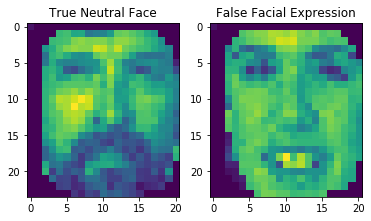

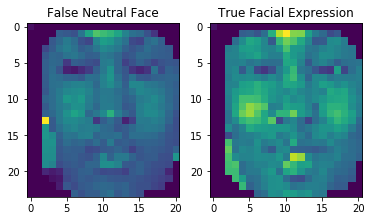

In [93]:
# Test accuracy
print("Total test accuracy: ", (nf_test_correct + fe_test_correct) / test.shape[0])

test_acc_table = np.array([[nf_test_correct, fe_test_error], 
                            [nf_test_error, fe_test_correct]])
test_acc_df = pd.DataFrame(test_acc_table, columns = ['Neutral Face','Facial Expression'])
test_acc_df = test_acc_df.rename(index={0: 'Predict 0', 1:'Predict 1'})
display(test_acc_df)

nf_precision = nf_test_correct / nf_test.shape[0]
fe_precision = fe_test_correct / fe_test.shape[0]
precision_table = np.array([[nf_precision, fe_precision]])
precision_df = pd.DataFrame(precision_table, columns = ['Neutral Face','Facial Expression'])
precision_df = precision_df.rename(index={0:'Precision'})
display(precision_df)

## Calculate false example
nf_test_correct_idxs_set = set(nf_test_correct_idxs)
nf_error_idx = -1
for i in range(nf_test.shape[0]):
    if not i in nf_test_correct_idxs_set:
        nf_error_idx = i
        break

fe_test_correct_idxs_set = set(fe_test_correct_idxs)
fe_error_idx = -1
for i in range(fe_test.shape[0]):
    if not i in fe_test_correct_idxs_set:
        fe_error_idx = i
        break
      
print("")
print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_test[nf_test_correct_idxs[0]].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_test[fe_error_idx].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax.set_title('False Neutral Face')
plt.imshow(nf_test[nf_error_idx].reshape((24, 21)))

ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_test[fe_test_correct_idxs[0]].reshape((24, 21)))

### K Nearest Neighbor (with LDA)

#### K=1

In [94]:
%%time
# Train Evaluation
train_predict = knn(train_data=projected_train, train_label=train_label, target=projected_train)
train_correct = np.sum(train_predict==train_label)
print("Total train accuracy: ", train_correct / train_label.shape[0])

Total train accuracy:  1.0
CPU times: user 7.86 ms, sys: 0 ns, total: 7.86 ms
Wall time: 6.7 ms


Total test accuracy:  0.7875


,Neutral Face,Facial Expression
Predict 0,31,8
Predict 1,9,32


,Neutral Face,Facial Expression
Precision,0.775,0.8


Example images
CPU times: user 156 ms, sys: 0 ns, total: 156 ms
Wall time: 152 ms


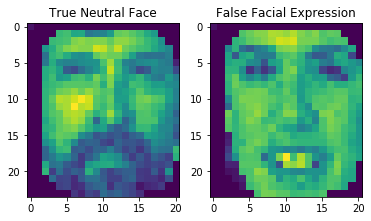

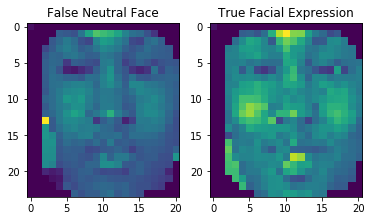

In [95]:
%%time
# Test Evaluation
test_predict = knn(train_data=projected_train, train_label=train_label, target=projected_test)
test_correct = np.sum(test_predict==test_label)
print("Total test accuracy: ", test_correct / test_label.shape[0])


## Create truth table
nf_test_predict = knn(train_data=projected_train, train_label=train_label, target=projected_nf_test)
nf_test_correct = np.sum(nf_test_predict==nf_test_label)
nf_test_error = nf_test.shape[0] - nf_test_correct

fe_test_predict = knn(train_data=projected_train, train_label=train_label, target=projected_fe_test)
fe_test_correct = np.sum(fe_test_predict==fe_test_label)
fe_test_error = fe_test.shape[0] - fe_test_correct

test_acc_table = np.array([[nf_test_correct, fe_test_error], 
                            [nf_test_error, fe_test_correct]])
test_acc_df = pd.DataFrame(test_acc_table, columns = ['Neutral Face','Facial Expression'])
test_acc_df = test_acc_df.rename(index={0: 'Predict 0', 1:'Predict 1'})
display(test_acc_df)

## Calculate precision
nf_precision = nf_test_correct / nf_test.shape[0]
fe_precision = fe_test_correct / fe_test.shape[0]
precision_table = np.array([[nf_precision, fe_precision]])
precision_df = pd.DataFrame(precision_table, columns = ['Neutral Face','Facial Expression'])
precision_df = precision_df.rename(index={0:'Precision'})
display(precision_df)

## Correct and error prediction images 
nf_correct_predict = nf_test[np.where(nf_test_predict==nf_test_label)]
nf_error_predict = nf_test[np.where(nf_test_predict!=nf_test_label)]
fe_correct_predict = fe_test[np.where(fe_test_predict==fe_test_label)]
fe_error_predict = fe_test[np.where(fe_test_predict!=fe_test_label)]

print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_correct_predict[0].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_error_predict[0].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax.set_title('False Neutral Face')
plt.imshow(nf_error_predict[0].reshape((24, 21)))

ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_correct_predict[0].reshape((24, 21)))

#### K=3

In [96]:
%%time
# Train Evaluation
train_predict = knn(train_data=projected_train, train_label=train_label, target=projected_train, k=3)
train_correct = np.sum(train_predict==train_label)
print("Total train accuracy: ", train_correct / train_label.shape[0])

Total train accuracy:  1.0
CPU times: user 8.21 ms, sys: 0 ns, total: 8.21 ms
Wall time: 6.71 ms


Total test accuracy:  0.7875


,Neutral Face,Facial Expression
Predict 0,31,8
Predict 1,9,32


,Neutral Face,Facial Expression
Precision,0.775,0.8


Example images
CPU times: user 30.8 ms, sys: 2.39 ms, total: 33.2 ms
Wall time: 29.5 ms


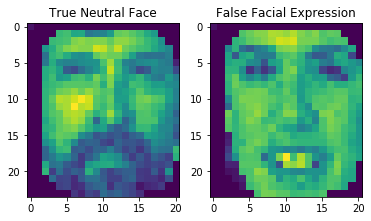

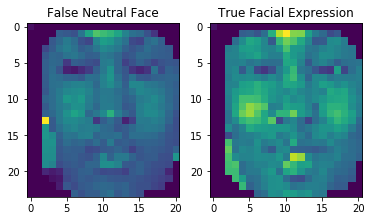

In [97]:
%%time
# Test Evaluation
test_predict = knn(train_data=projected_train, train_label=train_label, target=projected_test, k=3)
test_correct = np.sum(test_predict==test_label)
print("Total test accuracy: ", test_correct / test_label.shape[0])


## Create truth table
nf_test_predict = knn(train_data=projected_train, train_label=train_label, target=projected_nf_test, k=3)
nf_test_correct = np.sum(nf_test_predict==nf_test_label)
nf_test_error = nf_test.shape[0] - nf_test_correct

fe_test_predict = knn(train_data=projected_train, train_label=train_label, target=projected_fe_test, k=3)
fe_test_correct = np.sum(fe_test_predict==fe_test_label)
fe_test_error = fe_test.shape[0] - fe_test_correct

test_acc_table = np.array([[nf_test_correct, fe_test_error], 
                            [nf_test_error, fe_test_correct]])
test_acc_df = pd.DataFrame(test_acc_table, columns = ['Neutral Face','Facial Expression'])
test_acc_df = test_acc_df.rename(index={0: 'Predict 0', 1:'Predict 1'})
display(test_acc_df)

## Calculate precision
nf_precision = nf_test_correct / nf_test.shape[0]
fe_precision = fe_test_correct / fe_test.shape[0]
precision_table = np.array([[nf_precision, fe_precision]])
precision_df = pd.DataFrame(precision_table, columns = ['Neutral Face','Facial Expression'])
precision_df = precision_df.rename(index={0:'Precision'})
display(precision_df)

## Correct and error prediction images 
nf_correct_predict = nf_test[np.where(nf_test_predict==nf_test_label)]
nf_error_predict = nf_test[np.where(nf_test_predict!=nf_test_label)]
fe_correct_predict = fe_test[np.where(fe_test_predict==fe_test_label)]
fe_error_predict = fe_test[np.where(fe_test_predict!=fe_test_label)]

print("Example images")
%matplotlib inline
subject = 7
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('True Neutral Face')
plt.imshow(nf_correct_predict[0].reshape((24, 21)))

ax = fig.add_subplot(1, 2, 2)
ax.set_title('False Facial Expression')
plt.imshow(fe_error_predict[0].reshape((24, 21)))

fig2 = plt.figure()
ax = fig2.add_subplot(1, 2, 1)
ax.set_title('False Neutral Face')
plt.imshow(nf_error_predict[0].reshape((24, 21)))

ax = fig2.add_subplot(1, 2, 2)
ax.set_title('True Facial Expression')
plt.imshow(fe_correct_predict[0].reshape((24, 21)))

### Kernel SVM (with LDA)

In [98]:
# Define neutral face with label 1
# Define facial expression with label -1
N, D = projected_nf_train.shape
nf_train_label = np.ones(N) 
N, D = projected_nf_test.shape
nf_test_label = np.ones(N) 

N, D = projected_fe_train.shape
fe_train_label = -1 * np.ones(N) 
N, D = projected_fe_test.shape
fe_test_label = -1 * np.ones(N) 

projected_train = np.vstack((projected_nf_train, projected_fe_train))
projected_test = np.vstack((projected_nf_test, projected_fe_test))
train_label = np.hstack((nf_train_label, fe_train_label))
test_label = np.hstack((nf_test_label, fe_test_label))

#### RBF kernel

In [99]:
%%time
rbf_svm_model = RBF_SVM_Model(projected_train, train_label, sig=3, r=0.01)
rbf_svm_model.train(epoch=1000, lr=5e-4)

Epoch 0, loss=0.47855082310900376
Epoch 50, loss=0.09881707280792251
Epoch 100, loss=0.0926636629932063
Epoch 150, loss=0.09132391085930072
Epoch 200, loss=0.09068287278913019
Epoch 250, loss=0.09046034477483653
Epoch 300, loss=0.09023852200330405
Epoch 350, loss=0.09001740434481106
Epoch 400, loss=0.08983729010528159
Epoch 450, loss=0.08981496816104093
Epoch 500, loss=0.08979251716936404
Epoch 550, loss=0.08977007178974755
Epoch 600, loss=0.08974763202078866
Epoch 650, loss=0.0897251978610848
Epoch 700, loss=0.0897027693092339
Epoch 750, loss=0.08968048122452191
Epoch 800, loss=0.0896580638504608
Epoch 850, loss=0.08963565208005674
Epoch 900, loss=0.089613245911909
Epoch 950, loss=0.08959084534461713
CPU times: user 3.57 s, sys: 705 ms, total: 4.28 s
Wall time: 3.71 s


In [100]:
acc, predicts = rbf_svm_model.predict_acc(projected_train, train_label)
print("Train accuracy: ", acc)

Train accuracy:  1.0


In [101]:
acc, predicts = rbf_svm_model.predict_acc(projected_test, test_label)
print("Train accuracy: ", acc)

Train accuracy:  0.7375


#### Polynomial kernel

In [102]:
poly_svm_model = Poly_SVM_Model(projected_train, train_label, gamma=1)
poly_svm_model.train(epoch=500, lr=1e-5)

Epoch 0, loss=36143.73147360364
Epoch 50, loss=29789.61073589456
Epoch 100, loss=32203.70385249249
Epoch 150, loss=34617.79696909043
Epoch 200, loss=28263.676231381345
Epoch 250, loss=30677.7693479793
Epoch 300, loss=33091.86246457723
Epoch 350, loss=35505.955581175134
Epoch 400, loss=29151.83484346608
Epoch 450, loss=31565.92796006401


In [103]:
acc, predicts = poly_svm_model.predict_acc(projected_train, train_label)
print("Train accuracy: ", acc)

Train accuracy:  0.5


In [104]:
acc, predicts = poly_svm_model.predict_acc(projected_test, test_label)
print("Test accuracy: ", acc)

Test accuracy:  0.575
